<a href="https://colab.research.google.com/github/Geetanjali-18/Potato-Disease-Detection/blob/main/Potato_Disease_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **POTATO DISEASE DETECTION **

In [4]:
# Import all the necessary libararies that you need to use in potato disease detection.

## WORKFLOW


In [5]:
import tensorflow as tf
from tensorflow.keras import models , layers
import matplotlib.pyplot as plt
from sys import getsizeof
from tensorflow import keras
import os
import numpy as np
import h5py
from sklearn.metrics import accuracy_score
import os
from sklearn.model_selection import train_test_split
import shutil
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,precision_score, recall_score, f1_score,classification_report
import numpy as np
import seaborn as sns
import random
import time
import copy


In [6]:
pip install timm

 1. **Batch size**:  "batch size" refers to the number of image utilized in one iteration. In other words, during the training process, the entire dataset is divided into smaller sets or batches, and each batch is used to update the model's parameters once.


 2. **"Channels"** typically refer to dimensions in the input or intermediate data representations.
Here we are using 3-channel (RGB) images.


 3. "***Epoch***" refers to one complete pass through the entire training dataset during the training phase of a model. During each epoch, the model is trained on the entire dataset, and the model parameters are updated based on the error or loss calculated from the predictions compared to the actual target values.
Here, epochs = 10 to avoid the problem of overfitting.


In [7]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 10

In [8]:
import zipfile
with zipfile.ZipFile("/content/PlantVillage.zip" , "r") as zip_ref:
     zip_ref.extractall("/content")

**"image_dataset_from_directory"** function to create a dataset for image classification tasks from a directory structure where each subdirectory represents a different class. Here's a breakdown of the parameters used in the function:

1. data_dir: The path to the directory containing the image data. This directory should have subdirectories, with each subdirectory representing a different class of images.

2. shuffle: A boolean parameter indicating whether to shuffle the data. Shuffling the data is typically done during training to ensure that the model sees a diverse set of examples in each batch.

3. image_size: A tuple specifying the desired size of the images in the dataset. Images will be resized to this size if they are not already in this size.

4. batch_size: The number of images to include in each batch of the dataset. This parameter determines how many images are processed simultaneously during training.


In [9]:
data_dir = '/content/PlantVillage'
data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir ,
    shuffle = True ,
    image_size = (IMAGE_SIZE , IMAGE_SIZE) ,
    batch_size = 32
)

Found 2152 files belonging to 3 classes.


### We have 3 classes in which we are classifying disease: "Potato___Early_blight", "Potato___Late_blight", "Potato___healthy"

In [10]:
class_names = data.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

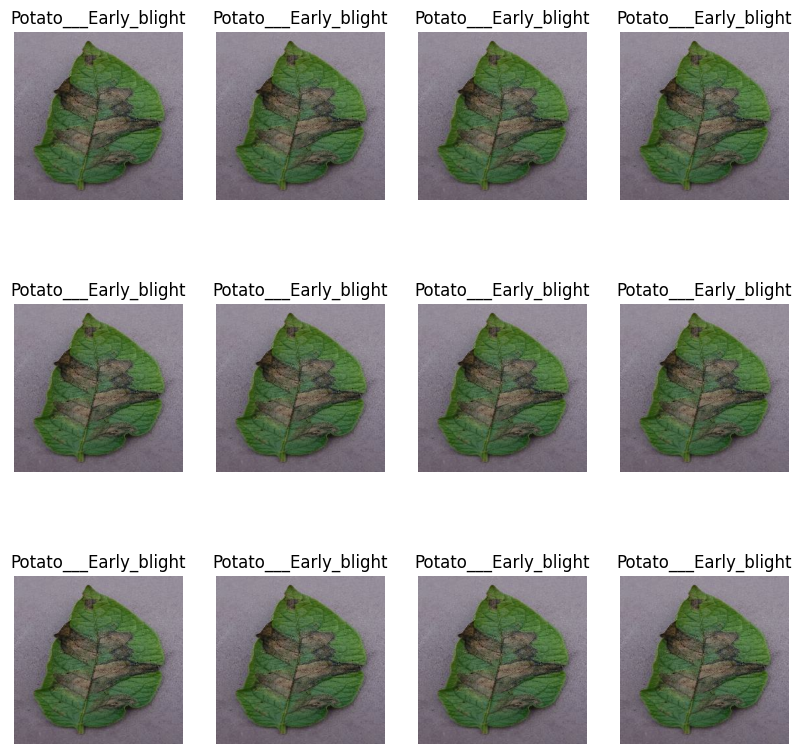

In [11]:
plt.figure(figsize = (10 , 10))
for image_batch , labe_batch in data.take(2):
 for i in range(12):
  ax = plt.subplot(3 , 4 , i+1)
  plt.imshow(image_batch[0].numpy().astype("uint8"))
  plt.title(class_names[labe_batch[1]])
  plt.axis("off")

The ***'get_dataset_partition'*** function is designed to split a dataset into training, validation, and test partitions. It shuffles the data if specified and then partitions it according to the specified splits. Here's a breakdown of how the function works:


*   data: The input dataset to be partitioned. This is assumed to be a TensorFlow Dataset object.
*   data: The input dataset to be partitioned. This is assumed to be a TensorFlow Dataset object.
*   val_split: The proportion of the data to be allocated for validation. Default is 0.1, meaning 10% of the data will be used for validation.
*  test_split: The proportion of the data to be allocated for testing. Default is 0.1, meaning 10% of the data will be used for testing.
* shuffle: A boolean indicating whether to shuffle the data before partitioning. Default is True.
*   shuffle_size: The buffer size used for shuffling the data. Default is 10,000.







In [12]:
def get_dataset_partition ( data , train_split = 0.8 , val_split = 0.1 , test_split = 0.1 , shuffle = True  , shuffle_size = 10000):

  if shuffle == True:
    data = data.shuffle(shuffle_size , seed = 12)
  ds_size = len(data)
  train_size = int(train_split*ds_size)
  val_size = int(val_split*ds_size)

  train_ds = data.take(train_size)
  val_ds = data.skip(train_size).take(val_size)
  test_ds = data.skip(train_size).skip(val_size)
  return train_ds , val_ds , test_ds

In [13]:
train_ds , val_ds , test_ds = get_dataset_partition(data)

In [14]:
len(train_ds)

54



*   Caching (cache()): Caching stores elements of the dataset in memory or on disk after they are loaded for the first time. This can speed up subsequent iterations through the dataset, especially when the dataset is small enough to fit into memory. Cached datasets should be small enough to fit into memory, otherwise, caching to disk might be more appropriate.
*   Shuffling (shuffle(1000)): Shuffling randomly shuffles the elements of the dataset. This is typically done during training to introduce randomness and prevent the model from learning the order of the examples. The argument 1000 specifies the buffer size for shuffling, which determines the number of elements used for shuffling at once.
* Prefetching (prefetch(buffer_size=tf.data.AUTOTUNE)): Prefetching overlaps data preprocessing and model execution. It fetches data batches in the background while the model is training on the current batch, effectively reducing the time wasted between batches. The argument tf.data.AUTOTUNE dynamically adjusts the buffer size based on available system resources, maximizing performance.



In [15]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [16]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE , IMAGE_SIZE) ,
    layers.experimental.preprocessing.Rescaling(1.0/255)
])


***In TensorFlow, Sequential is a type of model provided by the Keras API, which is a high-level neural networks API that makes building and training neural networks more straightforward. The Sequential model is a linear stack of layers, where each layer has exactly one input tensor and one output tensor.***


In below lines code defines a TensorFlow Sequential model composed of two preprocessing layers:
* Resizing Layer (Resizing): This layer resizes input images to a specified target size. In your code, it resizes images to IMAGE_SIZE by IMAGE_SIZE pixels. The Resizing layer is helpful for ensuring that all images in the dataset have the same dimensions, which is often required for training neural networks.

* Rescaling Layer (Rescaling): This layer scales pixel values of input images. In your code, it rescales pixel values by dividing them by 255.0, which effectively normalizes pixel values to the range [0, 1]. Normalizing pixel values is a common preprocessing step in deep learning models, as it helps stabilize and speed up the training process.

In [17]:
data_augumentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical")
    ,layers.experimental.preprocessing.RandomRotation(0.2) ,
])

*Preprocessing Layers*: The resize_and_rescale layer is applied to resize and rescale input images. data_augmentation is presumably a layer or a set of layers for data augmentation, but it's not defined in the provided code snippet.

*Convolutional Layer*s: Several convolutional layers (Conv2D) with ReLU activation functions are defined. These layers are responsible for learning spatial hierarchies of features from the input images.

*MaxPooling Layers*: After each convolutional layer, max-pooling layers (MaxPooling2D) are applied to downsample the spatial dimensions of the feature maps, reducing computational complexity and extracting dominant features.

***Flatten Layer:*** The Flatten layer is used to flatten the output of the last convolutional layer into a vector, which can then be fed into a fully connected (dense) layer.

*Dense Layers*: Two fully connected (Dense) layers with ReLU activation functions are defined. The last dense layer has n units and uses the softmax activation function, suitable for multi-class classification tasks where n represents the number of classes.

Model Building: The build method is called to build the model with the specified input_shape

In [18]:
n = 3
input_shape = (BATCH_SIZE , IMAGE_SIZE , IMAGE_SIZE , CHANNELS)
model = models.Sequential([
    resize_and_rescale ,
    data_augumentation ,
    layers.Conv2D(32 , (3 , 3) , activation = "relu" , input_shape = input_shape),
    layers.MaxPooling2D((2 , 2)),
    layers.Conv2D(64 , kernel_size = (3 , 3) , activation = 'relu') ,
    layers.MaxPooling2D((2 , 2)) ,
    layers.Conv2D(64 , kernel_size = (3 , 3) , activation = 'relu') ,
    layers.MaxPooling2D((2 , 2)) ,
    layers.Conv2D(64 ,(3 , 3) ,  activation = 'relu') ,
    layers.MaxPooling2D((2 , 2)) ,
    layers.Flatten() ,
    layers.Dense(64 , activation = 'relu') ,
    layers.Dense(n , activation = "softmax")
])

model.build(input_shape = input_shape)

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [20]:
model.compile(
    optimizer = 'adam' ,
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False) ,
    metrics = ['accuracy']
)

In [21]:
model.fit(
    train_ds ,
    epochs = EPOCHS ,
    batch_size = BATCH_SIZE ,
    verbose = 1 ,
    validation_data = val_ds
)

Epoch 1/10
54/54 [==============================] - 22s 167ms/step - loss: 0.6587 - accuracy: 0.7211 - val_loss: 0.5080 - val_accuracy: 0.8438
Epoch 2/10
54/54 [==============================] - 4s 69ms/step - loss: 0.3407 - accuracy: 0.8623 - val_loss: 0.2355 - val_accuracy: 0.9219
Epoch 3/10
54/54 [==============================] - 4s 71ms/step - loss: 0.2643 - accuracy: 0.9039 - val_loss: 0.2199 - val_accuracy: 0.9323
Epoch 4/10
54/54 [==============================] - 3s 60ms/step - loss: 0.2094 - accuracy: 0.9219 - val_loss: 0.2424 - val_accuracy: 0.9115
Epoch 5/10
54/54 [==============================] - 3s 59ms/step - loss: 0.1766 - accuracy: 0.9323 - val_loss: 0.2343 - val_accuracy: 0.9115
Epoch 6/10
54/54 [==============================] - 3s 60ms/step - loss: 0.1372 - accuracy: 0.9497 - val_loss: 0.1121 - val_accuracy: 0.9531
Epoch 7/10
54/54 [==============================] - 3s 60ms/step - loss: 0.1519 - accuracy: 0.9392 - val_loss: 0.1677 - val_accuracy: 0.9427
Epoch 8/10


In [24]:
import os
model_version=max([int(i) for i in os.listdir("/content/model") + [0]])+1
model.save(f"/content/model/{model_version}")

In [25]:
keras_model = "potato_disease.h5"
model.save(keras_model)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [26]:
def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

In [27]:
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

In [28]:
convert_bytes(get_file_size(keras_model) , "MB")

File size: 10.319 Megabytes


In [29]:
tlm = "tf_lite_model.tflite"

In [30]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()

In [31]:
tflite_model_name = tlm
open(tflite_model_name, "wb").write(tflite_model)

3590672

In [32]:
convert_bytes(get_file_size(tlm) , "MB")

File size: 3.424 Megabytes


In [33]:
interpreter = tf.lite.Interpreter(model_path = tlm)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:" , input_details[0]['shape'])
print("Input type" , input_details[0]['dtype'])
print("Output shape" , output_details[0]['shape'])
print("Output type" , output_details[0]['dtype'])


Input Shape: [  1 256 256   3]
Input type <class 'numpy.float32'>
Output shape [1 3]
Output type <class 'numpy.float32'>


In [34]:
interpreter.resize_tensor_input(input_details[0]['index'], (5000, IMAGE_SIZE, IMAGE_SIZE , 3))
interpreter.resize_tensor_input(output_details[0]['index'], (5000, 3))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [5000  256  256    3]
Input Type: <class 'numpy.float32'>
Output Shape: [5000    3]
Output Type: <class 'numpy.float32'>
